# **1. Import necessary libraries**

In [29]:
import os
import tweepy as tw
import pandas as pd
import csv
import pandas as pd
import glob
from nltk.corpus import stopwords
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
import keras.models
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras import backend as K
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers.merge import concatenate
from numpy import argmax
import pickle

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Necessary Data Cleaning Functions**

In [31]:
def create_data_corpus(path):
  files = glob.glob(path + "/*.csv")
  df_list = []
  
  for file in files:
    df = pd.read_csv(file, index_col=None, header=0, engine='python')
    df_list.append(df)

  frame = pd.concat(df_list, axis=0, ignore_index=True)
  return frame

In [32]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt

In [33]:
def clean_tweets(frame, column_name, remove_stop_words=True, lower_case=True, remove_special=True):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs

  if remove_special:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words
  if lower_case:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: x.lower())
  if remove_stop_words:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')])) #remove stop words

  return frame

# **3. Preprocess the Dataset(Combined corpus of SemEval2017 + Airlines + subset of Sentiment140) for training the Networks**

In [34]:
mega_frame = create_data_corpus('/content/drive/MyDrive/SentimentAnalysis/MegaData') #Use this path only (Modify if needed)
mega_frame = clean_tweets(frame=mega_frame, column_name='Column3', remove_stop_words=False, remove_special=False)
mega_frame

,Column1,Column2,Column3,Tweet_Clean_Text
0,1.551359e+09,negative,@Descending yeah yeah offer it now I'm halfway...,yeah yeah offer it now i'm halfway home
1,2.191006e+09,positive,"@coopes64 someone tweeted it this time, but I'...","someone tweeted it this time, but i've seen i..."
2,1.556787e+09,negative,BTW I Don't live in the country I am Suburbia...,btw i don't live in the country i am suburbia ...
3,1.557363e+09,negative,@tiaralynn lol. i got the bg from createblog.c...,lol. i got the bg from createblog.com. i was ...
4,2.190198e+09,positive,"@juzferyou well, not all that cheap i reckon b...","well, not all that cheap i reckon but cute......"
...,...,...,...,...
114213,6.398560e+17,positive,@Racalto_SK ok good to know. Punting at MetLif...,ok good to know. punting at metlife in decemb...
114214,6.399800e+17,neutral,everyone who sat around me at metlife was so a...,everyone who sat around me at metlife was so a...
114215,6.401970e+17,neutral,what giants or niners fans would wanna go to t...,what giants or niners fans would wanna go to t...
114216,6.409760e+17,positive,Anybody want a ticket for tomorrow Colombia vs...,anybody want a ticket for tomorrow colombia vs...


# **4. Build the Inputs to our networks**

**One-hot encode the labels**

In [35]:
mega_frame["Sentiment_Value"] = mega_frame["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
labels = to_categorical(mega_frame["Sentiment_Value"], 3)
mega_frame

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,1.551359e+09,negative,@Descending yeah yeah offer it now I'm halfway...,yeah yeah offer it now i'm halfway home,2
1,2.191006e+09,positive,"@coopes64 someone tweeted it this time, but I'...","someone tweeted it this time, but i've seen i...",1
2,1.556787e+09,negative,BTW I Don't live in the country I am Suburbia...,btw i don't live in the country i am suburbia ...,2
3,1.557363e+09,negative,@tiaralynn lol. i got the bg from createblog.c...,lol. i got the bg from createblog.com. i was ...,2
4,2.190198e+09,positive,"@juzferyou well, not all that cheap i reckon b...","well, not all that cheap i reckon but cute......",1
...,...,...,...,...,...
114213,6.398560e+17,positive,@Racalto_SK ok good to know. Punting at MetLif...,ok good to know. punting at metlife in decemb...,1
114214,6.399800e+17,neutral,everyone who sat around me at metlife was so a...,everyone who sat around me at metlife was so a...,0
114215,6.401970e+17,neutral,what giants or niners fans would wanna go to t...,what giants or niners fans would wanna go to t...,0
114216,6.409760e+17,positive,Anybody want a ticket for tomorrow Colombia vs...,anybody want a ticket for tomorrow colombia vs...,1


**Get statistics of our data**

In [36]:
mega_frame['test'] = mega_frame['Tweet_Clean_Text'].apply(lambda x: len(str(x).split()))
print("mean length of sentence: " + str(mega_frame.test.mean()))
print("max length of sentence: " + str(mega_frame.test.max()))
print("std dev length of sentence: " + str(mega_frame.test.std()))

mean length of sentence: 15.85478646097813
max length of sentence: 39
std dev length of sentence: 6.794046007912892


**Vectorize and convert text into sequences**

In [37]:
maxlen = mega_frame.test.max()
with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)
  
tokenizer.fit_on_texts(mega_frame['Tweet_Clean_Text'].values)
num_features = len(tokenizer.word_index) + 1
X = tokenizer.texts_to_sequences(mega_frame['Tweet_Clean_Text'].values)
X = pad_sequences(X, maxlen=maxlen, padding='post')

print("Vocab size: ", num_features)
print("Input shape: ", X.shape)
print("Labels shape: " , labels.shape)

Vocab size:  73456
Input shape:  (114218, 39)
Labels shape:  (114218, 3)


**Create Training, Validation, and Test Data splits**

In [38]:
#FINAL DATASETS (Please note case sensitivity)- TRAINING: (X_train,Y_train)  VALIDATION: (X_val, Y_val)  TEST: (X_test, Y_test)

Y = labels

x_train, X_test, y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 1)

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=1)

# **Model helpers (metrics, callbacks, plots)**

### **Metrics**

In [39]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1_metrics'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
]

### **Training Plots**

In [40]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 15, 10

def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_metrics']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

### **Callbacks**

In [41]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3, verbose=1)

# **Ensembling Techniques**

## **Stacked Predictions**

In [42]:
# stacked generalization with neural net meta model on blobs dataset

# load models from file
def load_all_models(model_names):
	all_models = list()
	for model_name in model_names:
		# define filename for this ensemble
		filename = '/content/drive/MyDrive/SentimentAnalysis/Models/' + model_name
		# load model from file
		model = load_model(filename,custom_objects={'f1_metrics':f1_metrics,'precision':precision_score,'recall':recall_score})
		# add to list of members
		model.summary()
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# load all models
members = ['LSTM200.h5','LSTM50.h5','LSTM100.h5','LSTM150.h5','LSTM250.h5','FLATCNN[2, 3, 4].h5','FLATCNN[3, 4, 5].h5','FLATCNN[5, 6, 7].h5','FLATCNN[7, 8, 9].h5','FLATCNN[9, 10, 11].h5']
members = load_all_models(members)

members_lstm = members[0:5]
members_cnn = members[5:]

print('Loaded %d models' % len(members))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 200)           14691200  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 39, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               641600    
_________________________________________________________________
dense (Dense)                (None, 3)                 1203      
Total params: 15,334,003
Trainable params: 15,334,003
Non-trainable params: 0
_________________________________________________________________
>loaded /content/drive/MyDrive/SentimentAnalysis/Models/LSTM200.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embeddin

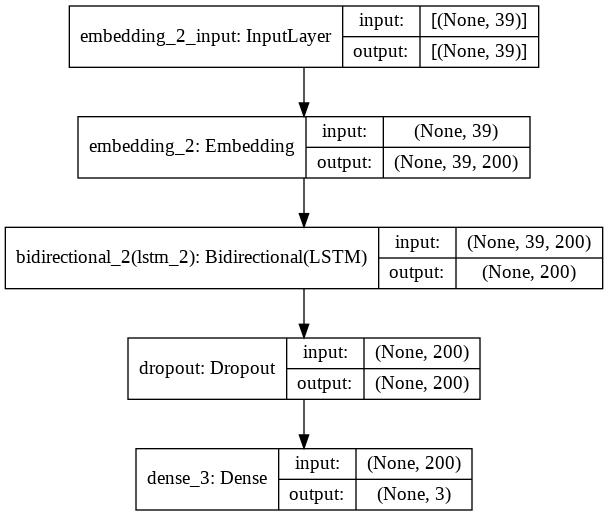

In [43]:
plot_model(members[2], show_shapes=True)

In [44]:
for i, model in enumerate(members):
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
  if i<5: 
    print("\nLSTM_Model_{0}".format(i+1))
  else:
    print("\nCNN_Model_{0}".format(i-4))
    
  model.evaluate(X_test, Y_test, batch_size=1000)



LSTM_Model_1
12/12 [==============================] - 2s 55ms/step - loss: 0.6333 - categorical_accuracy: 0.7345 - precision: 0.7461 - recall: 0.7174 - f1_metrics: 0.7312

LSTM_Model_2
12/12 [==============================] - 2s 30ms/step - loss: 0.6700 - categorical_accuracy: 0.7237 - precision: 0.7384 - recall: 0.7043 - f1_metrics: 0.7072

LSTM_Model_3
12/12 [==============================] - 2s 36ms/step - loss: 0.6478 - categorical_accuracy: 0.7201 - precision: 0.7354 - recall: 0.6985 - f1_metrics: 0.7172

LSTM_Model_4
12/12 [==============================] - 2s 40ms/step - loss: 0.6419 - categorical_accuracy: 0.7200 - precision: 0.7354 - recall: 0.6979 - f1_metrics: 0.7229

LSTM_Model_5
12/12 [==============================] - 2s 53ms/step - loss: 0.6547 - categorical_accuracy: 0.7199 - precision: 0.7357 - recall: 0.6978 - f1_metrics: 0.7189

CNN_Model_1
12/12 [==============================] - 1s 14ms/step - loss: 0.7928 - categorical_accuracy: 0.7139 - precision: 0.7302 - recal

In [45]:
train_predictions = []
val_predictions = []
test_predictions = []

train_lstm_predictions = []
val_lstm_predictions = []
test_lstm_predictions = []

train_cnn_predictions = []
val_cnn_predictions = []
test_cnn_predictions = []

for model in members:
  train_predictions.append(model.predict([X_train], batch_size=1024))
  val_predictions.append(model.predict([X_val], batch_size=1024))
  test_predictions.append(model.predict([X_test], batch_size=1024))
  print('Predicted one thing')

for lstm_model in members_lstm:
  train_lstm_predictions.append(lstm_model.predict([X_train], batch_size=1024))
  val_lstm_predictions.append(lstm_model.predict([X_val], batch_size=1024))
  test_lstm_predictions.append(lstm_model.predict([X_test], batch_size=1024))
  print('Predicted using lstm model')

for cnn_model in members_cnn:
  train_cnn_predictions.append(cnn_model.predict([X_train], batch_size=1024))
  val_cnn_predictions.append(cnn_model.predict([X_val], batch_size=1024))
  test_cnn_predictions.append(cnn_model.predict([X_test], batch_size=1024))
  print('Predicted using cnn model')


Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted one thing
Predicted using lstm model
Predicted using lstm model
Predicted using lstm model
Predicted using lstm model
Predicted using lstm model
Predicted using cnn model
Predicted using cnn model
Predicted using cnn model
Predicted using cnn model
Predicted using cnn model


In [46]:
from keras.layers import BatchNormalization
def ensemble(predictions, targets, xval, yval):
    layer_size = len(predictions)
    inp = Input(shape=(layer_size,3))
    f0 = Flatten()(inp)
    d0 = Dropout(0.2)(f0)
    d0 = Dense(pow(layer_size, 4))(d0)
    d1 = Dropout(0.2)(d0)
    d1 = Dense(20 * layer_size)(d1)
    b = BatchNormalization()(d1)
    out = Dropout(0.2)(b)
    out = Dense(3, activation='sigmoid')(out)

    model = Model(inputs=inp, outputs=out)
    metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
  ]
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    model.summary()

    x = np.array(list(zip(*np.squeeze(predictions))))
    y = targets
    print(np.shape(x))
    print(np.shape(y))

    xval = np.array(list(zip(*np.squeeze(xval))))
    yval = yval
    
    history = model.fit(x=x, y=y, epochs=50,batch_size=3000, validation_data=(xval,yval), verbose=2, callbacks=[early_stopping_callback, reduce_lr_callback])
    #display_model_history(history_flat_CNN) 
    #plot_metrics(history_flat_CNN)
    return model, history

In [47]:
y_train_cat = Y_train
y_val_cat = Y_val
y_test_cat = Y_test  

# Combined model
stack_model, history = ensemble(train_predictions, y_train_cat, val_predictions, y_val_cat)

stacked_test_predictions = np.array(list(zip(*np.squeeze(test_predictions))))
stacked_test_predictions = stack_model.predict(stacked_test_predictions, batch_size=1024)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 3)]           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 30)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10000)             310000    
_________________________________________________________________
dropout_10 (Dropout)         (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               2000200   
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800 

In [48]:
# Combined lstm models
stacked_model_lstm, history_stacked_lstm = ensemble(train_lstm_predictions, y_train_cat, val_lstm_predictions, y_val_cat)

stacked_test_lstm_predictions = np.array(list(zip(*np.squeeze(test_lstm_predictions))))
stacked_test_lstm_predictions = stacked_model_lstm.predict(stacked_test_lstm_predictions, batch_size=1024)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 3)]            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 15)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 625)               10000     
_________________________________________________________________
dropout_13 (Dropout)         (None, 625)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               62600     
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400 

In [49]:
# Combined cnn models
stacked_model_cnn, history_stacked_cnn = ensemble(train_cnn_predictions, y_train_cat, val_cnn_predictions, y_val_cat)

stacked_test_cnn_predictions = np.array(list(zip(*np.squeeze(test_cnn_predictions))))
stacked_test_cnn_predictions = stacked_model_cnn.predict(stacked_test_cnn_predictions, batch_size=1024)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5, 3)]            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 15)                0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 625)               10000     
_________________________________________________________________
dropout_16 (Dropout)         (None, 625)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               62600     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400 

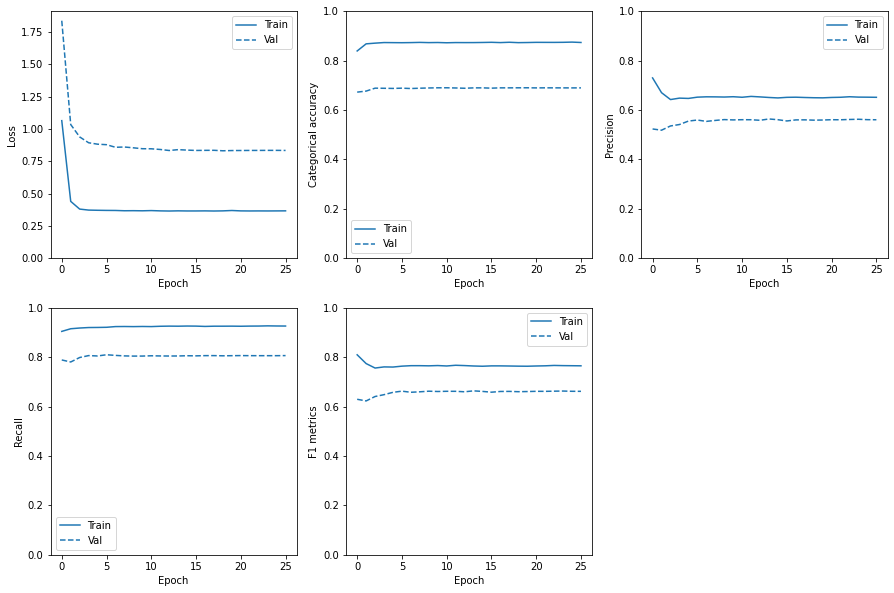

In [50]:
plot_metrics(history)

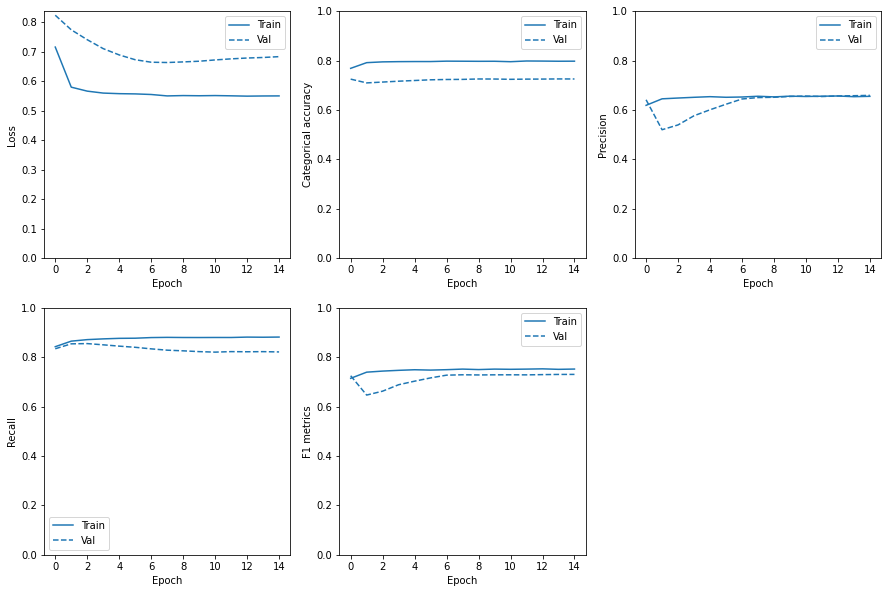

In [51]:
plot_metrics(history_stacked_lstm)

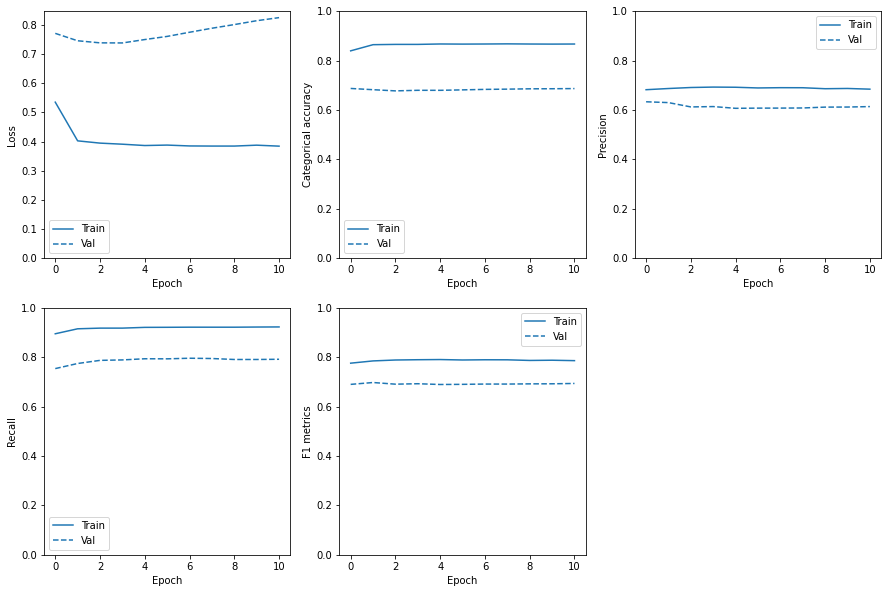

In [52]:
plot_metrics(history_stacked_cnn)

In [53]:
stack_model.evaluate(np.array(list(zip(*np.squeeze(test_predictions)))),y_test_cat)

357/357 [==============================] - 1s 4ms/step - loss: 0.8243 - categorical_accuracy: 0.6976 - precision: 0.5593 - recall: 0.8082 - f1_metrics: 0.6613


[0.8242743015289307,
 0.6976011395454407,
 0.559285044670105,
 0.8081771731376648,
 0.6612508893013]

In [54]:
stacked_model_lstm.evaluate(np.array(list(zip(*np.squeeze(test_lstm_predictions)))),y_test_cat)

357/357 [==============================] - 1s 3ms/step - loss: 0.6834 - categorical_accuracy: 0.7269 - precision: 0.6589 - recall: 0.8209 - f1_metrics: 0.7313


[0.6834322214126587,
 0.7269304990768433,
 0.6589359641075134,
 0.8208720088005066,
 0.7313334345817566]

In [55]:
stacked_model_cnn.evaluate(np.array(list(zip(*np.squeeze(test_cnn_predictions)))),y_test_cat)

357/357 [==============================] - 1s 3ms/step - loss: 0.8173 - categorical_accuracy: 0.6888 - precision: 0.6174 - recall: 0.7937 - f1_metrics: 0.6948


[0.8173044323921204,
 0.6888461112976074,
 0.6174067258834839,
 0.7937313914299011,
 0.6948197484016418]

## **Stacking Generalization**



In [57]:
from keras.layers import BatchNormalization

def define_stacked_model(members_here):
	# update all layers in all models to not be trainable
	for i in range(len(members_here)):
		model = members_here[i]
		model._name = "ensemble_"+str(i)
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			#print (layer.name)
			layer._name = 'stack_' + str(i+1) + '_' + layer.name
		#plot_model(model, show_shapes=True)
	# define multi-headed input
	ensemble_visible = [model.input for model in members_here]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members_here]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	h1 = Dropout(0.2)(hidden)
	h2 = BatchNormalization()(h1)
	output = Dense(3, activation='softmax')(h2)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
	return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	newdev = [X_val for _ in range(len(model.input))]
	# encode output data
	#inputy_enc = to_categorical(inputy)
	# fit model
	#history=model.fit(X, inputy, epochs=2, verbose=2,validation_data=(newdev, Y_dev_cat))
	history=model.fit(X, Y_train, epochs = 20, batch_size=1024, validation_data=(newdev,Y_val), verbose=2, callbacks=[early_stopping_callback, reduce_lr_callback])
 	#history = model.fit(x=x, y=y, epochs=50,batch_size=3000, validation_data=(xval,yval), verbose=2, callbacks=[early_stopping_callback, reduce_lr_callback])
	return history
	#model.fit(X, inputy, epochs=20, verbose=2)

# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	#return model.predict(X, verbose=0)
	return model.evaluate(X,y_test_cat)


In [58]:
stacked_all_model = define_stacked_model(members)
# fit stacked model on test dataset
history = fit_stacked_model(stacked_all_model, X_train,Y_train)
# make predictions and evaluate

Epoch 1/20
91/91 - 100s - loss: 1.1536 - categorical_accuracy: 0.5652 - precision: 0.6111 - recall: 0.5073 - f1_metrics: 0.3612 - val_loss: 0.8843 - val_categorical_accuracy: 0.6170 - val_precision: 0.7544 - val_recall: 0.4781 - val_f1_metrics: 0.5974
Epoch 2/20
91/91 - 77s - loss: 0.5944 - categorical_accuracy: 0.7496 - precision: 0.8118 - recall: 0.6876 - f1_metrics: 0.7447 - val_loss: 0.7364 - val_categorical_accuracy: 0.6955 - val_precision: 0.7297 - val_recall: 0.6433 - val_f1_metrics: 0.6869
Epoch 3/20
91/91 - 76s - loss: 0.4988 - categorical_accuracy: 0.8213 - precision: 0.8548 - recall: 0.7698 - f1_metrics: 0.8100 - val_loss: 0.7298 - val_categorical_accuracy: 0.6947 - val_precision: 0.7143 - val_recall: 0.6660 - val_f1_metrics: 0.6940
Epoch 4/20
91/91 - 76s - loss: 0.4482 - categorical_accuracy: 0.8447 - precision: 0.8697 - recall: 0.8062 - f1_metrics: 0.8368 - val_loss: 0.7626 - val_categorical_accuracy: 0.6876 - val_precision: 0.7025 - val_recall: 0.6654 - val_f1_metrics: 0.

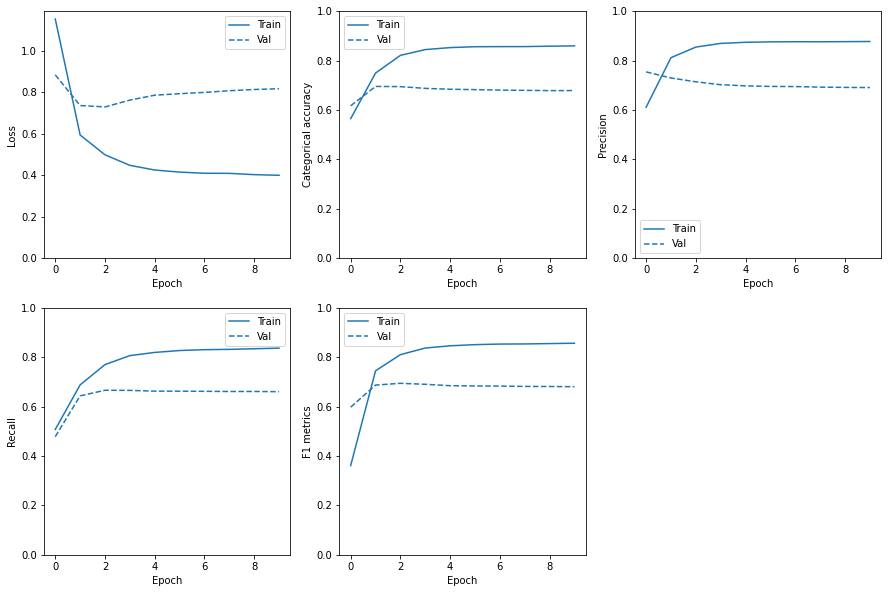

In [59]:
plot_metrics(history)

In [60]:
predict_stacked_model(stacked_all_model, X_test)

357/357 [==============================] - 52s 147ms/step - loss: 0.8164 - categorical_accuracy: 0.6778 - precision: 0.6924 - recall: 0.6609 - f1_metrics: 0.6760


[0.8164388537406921,
 0.6778147220611572,
 0.6923782229423523,
 0.6609175205230713,
 0.6759520173072815]

In [61]:
# define lstm ensemble model
stacked_lstm_model = define_stacked_model(members_lstm)
# fit stacked model on test dataset
history = fit_stacked_model(stacked_lstm_model, X_train,Y_train)

Epoch 1/20
91/91 - 95s - loss: 0.8935 - categorical_accuracy: 0.6181 - precision: 0.6601 - recall: 0.5432 - f1_metrics: 0.5831 - val_loss: 0.7804 - val_categorical_accuracy: 0.6925 - val_precision: 0.7712 - val_recall: 0.5354 - val_f1_metrics: 0.6375
Epoch 2/20
91/91 - 75s - loss: 0.6220 - categorical_accuracy: 0.7518 - precision: 0.7902 - recall: 0.6983 - f1_metrics: 0.7409 - val_loss: 0.6969 - val_categorical_accuracy: 0.7149 - val_precision: 0.7604 - val_recall: 0.6455 - val_f1_metrics: 0.7024
Epoch 3/20
91/91 - 74s - loss: 0.5901 - categorical_accuracy: 0.7712 - precision: 0.8040 - recall: 0.7224 - f1_metrics: 0.7609 - val_loss: 0.6685 - val_categorical_accuracy: 0.7208 - val_precision: 0.7533 - val_recall: 0.6741 - val_f1_metrics: 0.7151
Epoch 4/20
91/91 - 75s - loss: 0.5741 - categorical_accuracy: 0.7780 - precision: 0.8084 - recall: 0.7300 - f1_metrics: 0.7671 - val_loss: 0.6680 - val_categorical_accuracy: 0.7220 - val_precision: 0.7479 - val_recall: 0.6866 - val_f1_metrics: 0.7

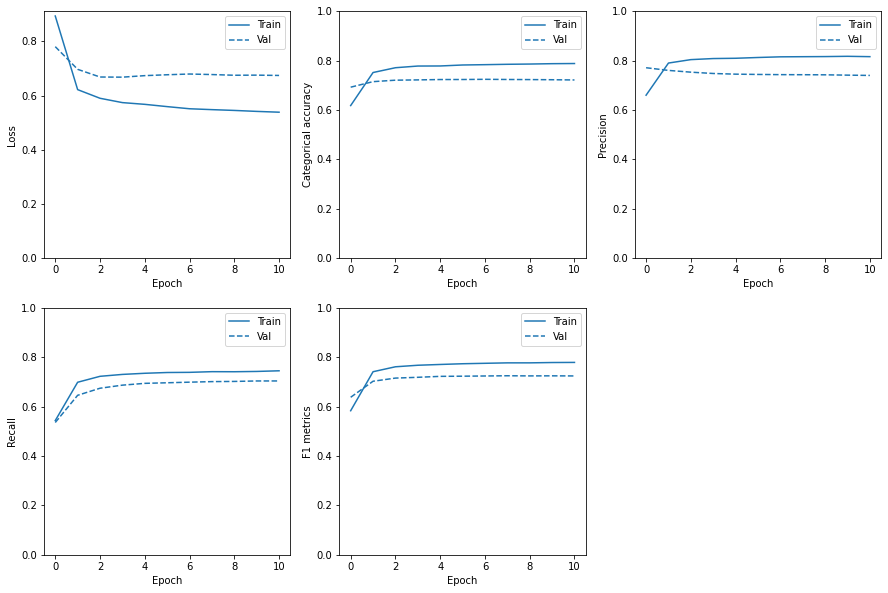

In [62]:
plot_metrics(history)

In [63]:
predict_stacked_model(stacked_lstm_model, X_test)

357/357 [==============================] - 51s 143ms/step - loss: 0.6772 - categorical_accuracy: 0.7275 - precision: 0.7432 - recall: 0.7029 - f1_metrics: 0.7221


[0.6772478818893433,
 0.7275433540344238,
 0.7431957125663757,
 0.7028541564941406,
 0.7221399545669556]

In [64]:
# define CNN ensemble model
stacked_cnn_model = define_stacked_model(members_cnn)
# fit stacked model on test dataset
history_cnn = fit_stacked_model(stacked_cnn_model, X_train,Y_train)
# make predictions and evaluate

Epoch 1/20
91/91 - 6s - loss: 0.5592 - categorical_accuracy: 0.7820 - precision: 0.8228 - recall: 0.7338 - f1_metrics: 0.7819 - val_loss: 0.8350 - val_categorical_accuracy: 0.6722 - val_precision: 0.7646 - val_recall: 0.4667 - val_f1_metrics: 0.5880
Epoch 2/20
91/91 - 4s - loss: 0.4251 - categorical_accuracy: 0.8533 - precision: 0.8712 - recall: 0.8307 - f1_metrics: 0.8506 - val_loss: 0.7840 - val_categorical_accuracy: 0.6818 - val_precision: 0.7172 - val_recall: 0.6223 - val_f1_metrics: 0.6731
Epoch 3/20
91/91 - 4s - loss: 0.4064 - categorical_accuracy: 0.8599 - precision: 0.8739 - recall: 0.8427 - f1_metrics: 0.8581 - val_loss: 0.7975 - val_categorical_accuracy: 0.6844 - val_precision: 0.7033 - val_recall: 0.6506 - val_f1_metrics: 0.6824
Epoch 4/20
91/91 - 4s - loss: 0.3980 - categorical_accuracy: 0.8625 - precision: 0.8755 - recall: 0.8470 - f1_metrics: 0.8609 - val_loss: 0.8329 - val_categorical_accuracy: 0.6842 - val_precision: 0.6981 - val_recall: 0.6625 - val_f1_metrics: 0.6860


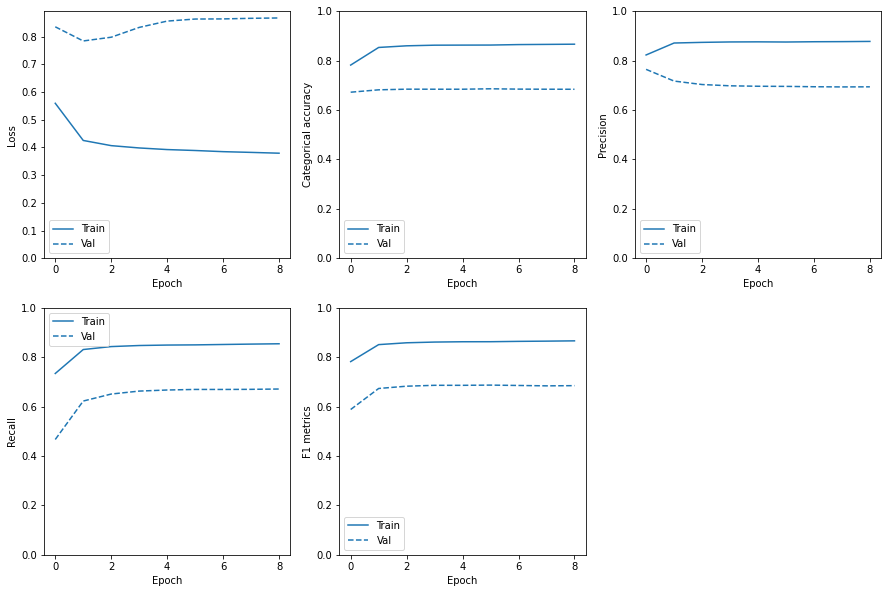

In [65]:
plot_metrics(history_cnn)

In [66]:
predict_stacked_model(stacked_cnn_model, X_test)

357/357 [==============================] - 3s 7ms/step - loss: 0.8631 - categorical_accuracy: 0.6874 - precision: 0.6966 - recall: 0.6743 - f1_metrics: 0.6851


[0.8630842566490173,
 0.6873577237129211,
 0.6965723037719727,
 0.6743127107620239,
 0.6850718855857849]